In [1]:
import pandas_datareader.data as web
import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

tcs = web.get_data_yahoo(['TSC'],start=datetime.datetime(2018,1,1),
                        end = datetime.datetime(2021,12,2))['Close']
print(tcs.head())

In [3]:
sbi = pd.read_csv('SBIN.NS.csv')
sbi.index = pd.to_datetime(sbi['Date'],format='%Y-%m-%d')

In [4]:
#sbi = sbi['Close']

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sns.set()

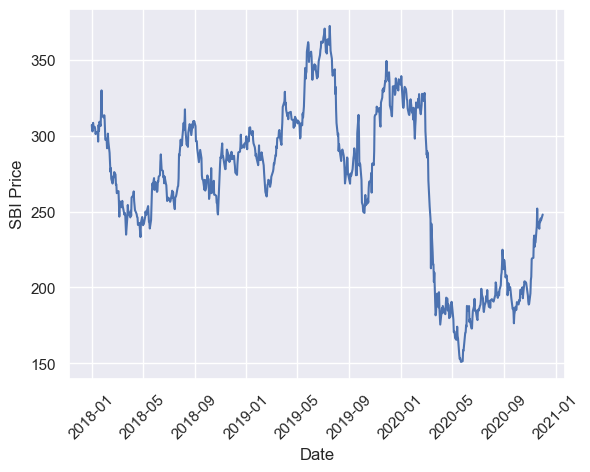

In [7]:
plt.ylabel('SBI Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(sbi.index,sbi['Close'],)
plt.show()

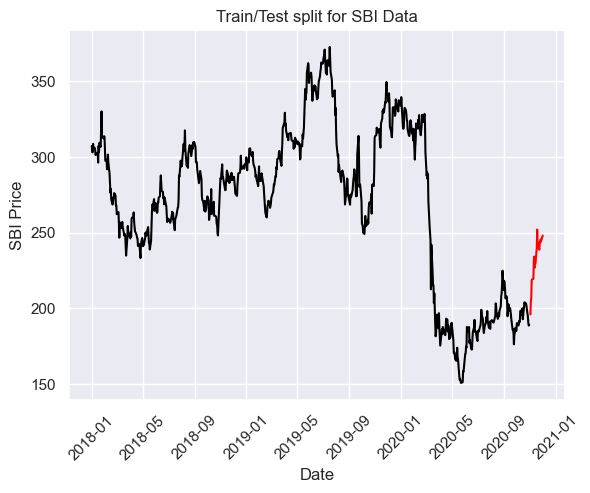

In [8]:
train = sbi[sbi.index < pd.to_datetime('2020-11-01',format = '%Y-%m-%d')]
test = sbi[sbi.index > pd.to_datetime('2020-11-01',format = '%Y-%m-%d')]


plt.plot(train['Close'],color = 'black')
plt.plot(test['Close'],color = 'red')
plt.ylabel('SBI Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title('Train/Test split for SBI Data')
plt.show()

In [9]:
import pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
y = train['Close']

In [11]:
model = pmdarima.auto_arima(y,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4545.549, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4553.705, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4554.385, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4554.523, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4552.203, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4555.572, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4555.792, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4554.224, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4554.221, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4555.050, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4557.870, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4557.586, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4546.836, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4544.090, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [12]:
model_1 = pmdarima.auto_arima(y, start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4555.050, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4553.705, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4554.385, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4554.523, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4552.203, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.376 seconds


In [13]:
arma = SARIMAX(y,order=(1,0,1))
arma = arma.fit()

C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
y_pred = arma.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df['Predictions'] = arma.predict(start=y_pred_df.index[0],
                                       end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['Predictions']

C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


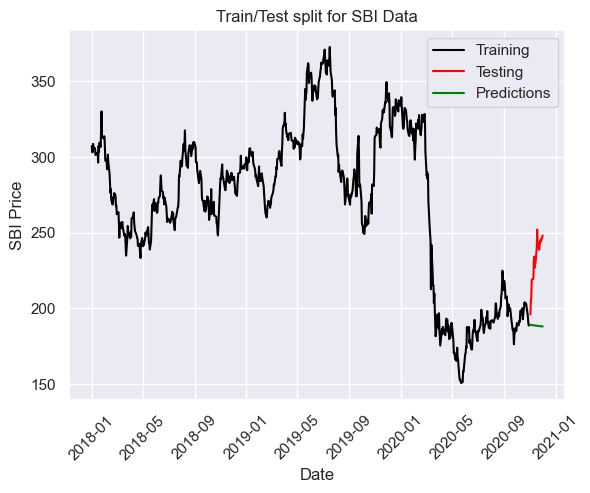

In [15]:
plt.plot(train['Close'],color = 'black',label='Training')
plt.plot(test['Close'],color = 'red',label='Testing')
plt.ylabel('SBI Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title('Train/Test split for SBI Data')
plt.plot(y_pred_out,color = 'green',label = 'Predictions')
plt.legend()
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test['Close'],
                                      y_pred_df['Predictions']))

print('RMSE: ',arma_rmse)

RMSE:  45.1983272630849


In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
arima = ARIMA(y,order=(2,2,2))
arima = arima.fit()

C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


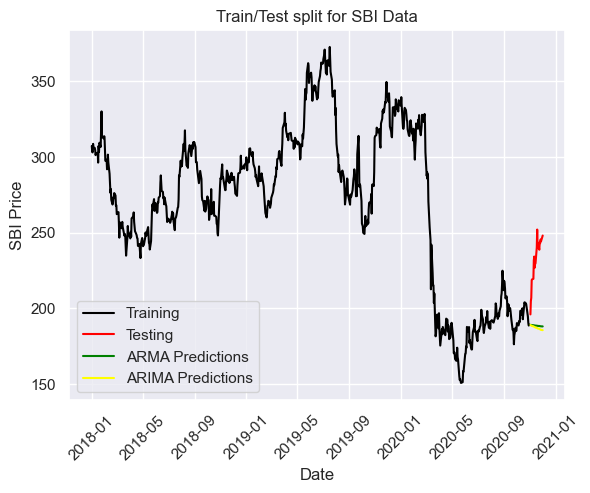

In [19]:
y_pred = arima.get_forecast(len(test.index))
y_pred_df1 = y_pred.conf_int(alpha=0.05)
y_pred_df1['Predictions'] = arima.predict(start = y_pred_df1.index[0],
                                         end = y_pred_df1.index[-1])
y_pred_df1.index = test.index
y_pred_out1 = y_pred_df1['Predictions']


plt.plot(train['Close'],color = 'black',label='Training')
plt.plot(test['Close'],color = 'red',label='Testing')
plt.ylabel('SBI Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title('Train/Test split for SBI Data')
plt.plot(y_pred_out,color = 'green',label = 'ARMA Predictions')
plt.plot(y_pred_out1,color = 'Yellow',label = 'ARIMA Predictions')
plt.legend()

In [20]:
arma_rmse = np.sqrt(mean_squared_error(test['Close'],
                                      y_pred_df['Predictions']))

print('RMSE: ',arma_rmse)

RMSE:  45.1983272630849


C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is ava

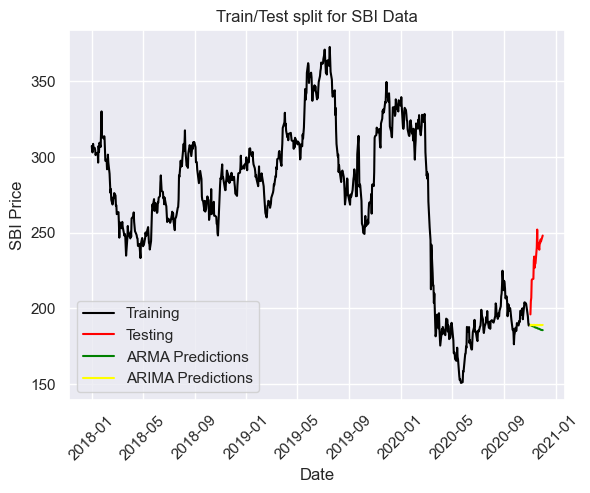

In [21]:
arima = ARIMA(y,order=(2,1,2))
arima = arima.fit()
y_pred = arima.get_forecast(len(test.index))
y_pred_df2 = y_pred.conf_int(alpha=0.05)
y_pred_df2['Predictions'] = arima.predict(start = y_pred_df2.index[0],
                                         end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2['Predictions']


plt.plot(train['Close'],color = 'black',label='Training')
plt.plot(test['Close'],color = 'red',label='Testing')
plt.ylabel('SBI Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title('Train/Test split for SBI Data')
plt.plot(y_pred_out1,color = 'green',label = 'ARMA Predictions')
plt.plot(y_pred_out2,color = 'Yellow',label = 'ARIMA Predictions')
plt.legend()

C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kiran\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results w

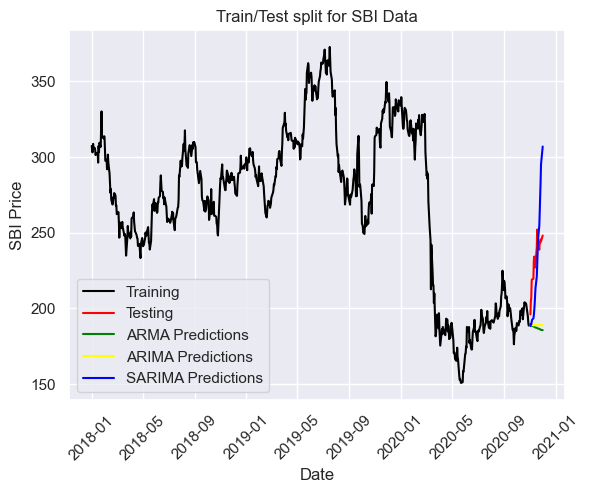

In [24]:
sarimax = SARIMAX(y,order = (5,4,2),seasonal_order = (2,1,2,12))
sarimax= sarimax.fit()

y_pred = sarimax.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = sarimax.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out_S = y_pred_df["Predictions"] 

plt.plot(train['Close'],color = 'black',label='Training')
plt.plot(test['Close'],color = 'red',label='Testing')
plt.ylabel('SBI Price')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.title('Train/Test split for SBI Data')
plt.plot(y_pred_out1,color = 'green',label = 'ARMA Predictions')
plt.plot(y_pred_out2,color = 'Yellow',label = 'ARIMA Predictions')
plt.plot(y_pred_out_S, color='Blue', label = 'SARIMA Predictions')
plt.legend()